In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#train, test and submission exmple
data = {'tra': pd.read_csv(r'...\train_set.csv', 
                           error_bad_lines=False, index_col=False, dtype='unicode'),
        'tes': pd.read_csv(r'...\test_set.csv', 
                           error_bad_lines=False, index_col=False, dtype='unicode'),
        'sub': pd.read_csv(r'...\sample.csv')}

In [6]:
data['tra'].shape

(1224734, 18)

In [5]:
data['tra'].head()

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
0,2.8840340071,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851000000000006,30.232,5261,NaN,59.84407235,30.1791526293,11606fde0c814ce78e0d726e39a0a5ee,2017-07-15,59.847,30.177
1,2.7756332035000004,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851000000000006,30.232,5261,NaN,59.84407235,30.1791526293,e9647a5e1eacfb06713b6af755ccc595,2017-10-27,59.847,30.177
2,3.7083683962,NaN,NaN,NaN,St Petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851000000000006,30.232,5992,"PR.MARSHALA ZHUKOVA,31St Petersburg190000 7...",59.85819839999999,30.229023699999996,df06c1fcd3718a514535ae822785f716,2017-10-03,59.847,30.177
3,2.7874978426,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851000000000006,30.232,5261,NaN,59.84407235,30.1791526293,6c5e5793ebc984fb72875feffff62854,2017-09-09,59.847,30.177
4,2.8925098831000002,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851000000000006,30.232,5261,NaN,59.84407235,30.1791526293,0576445d74e374c92c0902e612fca356,2017-07-06,59.847,30.177


In [12]:
data['tra'].mcc = data['tra'].mcc.astype(int)

In [13]:
#upload mcc codes description
mcc_codes = pd.read_csv(r'C:...\mcc_codes.csv')

data['tra'] = pd.merge(data['tra'], mcc_codes, on='mcc', how='left')

In [14]:
#currency
currency = pd.read_excel(r'...\currency.xlsx')
currency.currency = currency.currency.astype(float)

data['tra'].currency = data['tra'].currency.astype(float)
data['tes'].currency = data['tes'].currency.astype(float)

data['tra'] = pd.merge(data['tra'], currency, on='currency', how='left')
data['tes'] = pd.merge(data['tes'], currency, on='currency', how='left')

In [15]:
# data cleansing
data['tra'].city = [str(i).lower() for i in data['tra'].city]
data['tes'].city = [str(i).lower() for i in data['tes'].city]

data['tra'].loc[data['tra'][data['tra'].country == 'RU '].index,'country'] = 'RUS'
data['tes'].loc[data['tes'][data['tes'].country == 'RU '].index,'country'] = 'RUS'

data['tra'].amount = [float(i) for i in data['tra'].amount]
data['tes'].amount = [float(i) for i in data['tes'].amount]


In [16]:
#to datetime
data['tra']['transaction_date'] = pd.to_datetime(data['tra']['transaction_date'])

data['tra']['year'] = data['tra']['transaction_date'].dt.year
data['tra']['month'] = data['tra']['transaction_date'].dt.month
data['tra']['week'] = data['tra']['transaction_date'].dt.week
data['tra']['day'] = data['tra']['transaction_date'].dt.day
data['tra']['dow'] = data['tra']['transaction_date'].dt.weekday

data['tes']['transaction_date'] = pd.to_datetime(data['tes']['transaction_date'])

data['tes']['year'] = data['tes']['transaction_date'].dt.year
data['tes']['month'] = data['tes']['transaction_date'].dt.month
data['tes']['week'] = data['tes']['transaction_date'].dt.week
data['tes']['day'] = data['tes']['transaction_date'].dt.day
data['tes']['dow'] = data['tes']['transaction_date'].dt.weekday

In [17]:
# train: wo work = 4842
print(data['tra'][['customer_id','work_add_lat','work_add_lon']].groupby('customer_id').count().work_add_lon.value_counts()[0])

# train: everybody has a home
#print(data['tra'][['customer_id','home_add_lat','home_add_lon']].groupby('customer_id').count().home_add_lon.value_counts()[0])
print(0)

4842
0


In [19]:
#print(len(np.unique(data['tra'].home_add_lon)), len(np.unique(data['tra'].home_add_lat)))
#print(len(np.unique(data['tra'].work_add_lon)), len(np.unique(data['tra'].work_add_lat)))

In [20]:
unique_id = pd.pivot_table(data['tra'], 
                          index=['customer_id','country'], values='amount', aggfunc=(np.size, np.sum)).reset_index()

unique_id = unique_id.groupby('customer_id').agg({'country':[np.size], 'size':[np.sum], 'sum':[np.sum]}).reset_index()
unique_id.columns = ['customer_id', 'country_count', 'tr_count', 'tr_sum']

In [21]:
unique_id.sort_values(by='country_count', ascending=0).head(10)

,customer_id,country_count,tr_count,tr_sum
2187,30f008d358b5c7b3dfd3feb94a174d28,12,89.0,338.102759
4991,6fe78d53351cf0a7d62f90ed29f02e68,8,291.0,896.214672
5933,84ae6d53c637e39f4e063641d9d5599f,7,135.0,434.803654
6873,9a89fba2c9fbd72d6f6c54850c931854,6,112.0,360.787740
1255,1d00b0ef214f4bd3fc1b62fba4cad434,6,82.0,245.368228
25,00ab4bcdef7c20583e61d5d2ac7617cb,6,180.0,526.525882
246,058530abee8794129e6d5ee1d48e11c9,6,53.0,100.679326
8058,b4d1767cf01d056382183d088113b962,6,200.0,620.542231
5655,7e8a5d6d5c263955a32adf90d926ae32,6,206.0,671.809559
8367,bf66305d0ec05abb6e6a6358acb8c2a1,6,167.0,446.374935


In [341]:
unique_country = data['tra'][['country','amount']].groupby('country').count()
unique_country.sort_values(by='amount', ascending=0).head(5)

,amount
country,
RUS,1220767
DEU,238
CZE,215
ITA,177
THA,177


In [367]:
unique_country = data['tra'][['currency_info','amount']].groupby('currency_info').agg([np.size, np.sum]).reset_index()
unique_country.columns = ['currency_info', 'count', 'sum']
unique_country['div'] = unique_country['sum'] / unique_country['count']
unique_country.sort_values(by='dev', ascending=0)[:10]

,currency_info,count,sum,dev
21,Канадский доллар,49.0,225.966831,4.611568
2,Албанский лек,1.0,4.037025,4.037025
29,Мексиканский песо,13.0,51.574669,3.967282
56,Японская йена,3.0,11.641865,3.880622
31,Монгольский тугрик,1.0,3.867362,3.867362
55,Южно-африканский рэнд,5.0,19.095053,3.819011
36,Перуанский соль,4.0,14.996832,3.749208
0,Австралийский доллар,5.0,18.540145,3.708029
6,Венгерский форинт,11.0,40.018636,3.638058
7,Вьетнамский донг,50.0,181.725455,3.634509


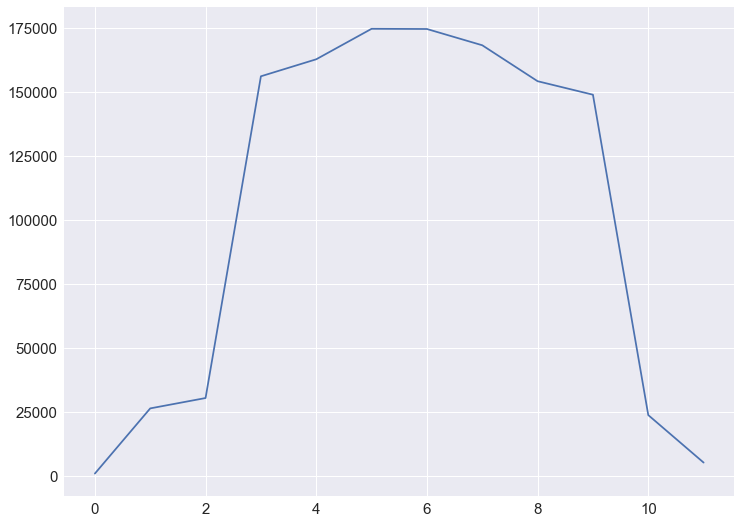

In [401]:
# gaps in time (as well as for test)
plt.plot(pd.pivot_table(data['tra'], index=['year','month'], values='amount', aggfunc= np.size).values)
plt.show();

In [490]:
data['tra'].home_add_lon = data['tra'].home_add_lon.apply(str)
data['tra'].home_add_lat = data['tra'].home_add_lat.apply(str)

data['tra'].work_add_lon = data['tra'].work_add_lon.apply(str)
data['tra'].work_add_lat = data['tra'].work_add_lat.apply(str)


In [676]:
data['tra']['home_add'] = data['tra'].home_add_lat + '_' + data['tra'].home_add_lon
data['tra']['work_add'] = data['tra'].work_add_lat + '_' + data['tra'].work_add_lon

In [626]:
# double home / double work
unique_home_add = data['tra'][['customer_id','home_add']].groupby('customer_id')['home_add'].nunique()
unique_work_add = data['tra'][['customer_id','work_add']].groupby('customer_id')['work_add'].nunique()

#len(unique_address.sort_values(ascending=0)[:337]), len(unique_work_add.sort_values(ascending=0)[:48])
print(data['tra']['home_add'].nunique(), data['tra']['work_add'].nunique())

10147 4585


In [681]:
unique_mcc = data['tra'][['edited_description', 'mcc', 'amount']].groupby(['edited_description', 'mcc']).agg(
    [np.size, np.sum]).reset_index()
unique_mcc.columns = ['edited_description', 'mcc', 'count', 'sum']
unique_mcc['div'] = unique_mcc['sum'] / unique_mcc['count']
unique_mcc.sort_values(by='count', ascending=0)[:10]

,edited_description,mcc,count,sum,div
112,"Grocery Stores, Supermarkets",5411,391635.0,1.005387e+06,2.567153
98,Financial Institutions – Manual Cash Disbursem...,6011,281885.0,1.006797e+06,3.571660
95,Fast Food Restaurants,5814,128771.0,3.085909e+05,2.396431
84,Eating places and Restaurants,5812,62407.0,1.605609e+05,2.572803
152,Misc. Food Stores – Convenience Stores and Spe...,5499,44703.0,1.055891e+05,2.362013
209,Service Stations ( with or without ancillary s...,5541,42296.0,1.222614e+05,2.890613
79,Drug Stores and Pharmacies,5912,41175.0,1.073606e+05,2.607423
136,Local/Suburban Commuter Passenger Transportati...,4111,24899.0,5.142199e+04,2.065223
177,"Package Stores – Beer, Wine, and Liquor",5921,18353.0,4.535579e+04,2.471301
236,Variety Stores,5331,13042.0,3.328535e+04,2.552166


In [613]:
len(unique_mcc), len(data['tra']['edited_description'].value_counts()), len(data['tra']['mcc'].value_counts())

(244, 242, 284)

In [679]:
one_home = pd.pivot_table(data['tra'][['customer_id', 'home_add', 'amount']], 
                          index=['customer_id', 'home_add'], values='amount', aggfunc=np.size).reset_index()
one_home = one_home.groupby('home_add').agg([np.size]).reset_index()
one_home.columns = ['home_add', 'id_count', 'loc_count']
one_home.sort_values(by='loc_count', ascending=0)[:10]

,home_add,id_count,loc_count
8867,59.924_30.311,3,3.0
2693,55.57_37.441,3,3.0
4708,55.758_37.658,3,3.0
405,45.086999999999996_39.012,3,3.0
8781,59.917_30.305999999999997,3,3.0
3774,55.687_37.863,3,3.0
229,44.894_37.301,3,3.0
8251,59.843999999999994_30.235,3,3.0
8656,59.898999999999994_30.474,2,2.0
4308,55.733000000000004_37.596,2,2.0


In [ ]:
# filtering cities 

In [685]:
%%time
data['tra'].loc[data['tra'][data['tra'].city == 'moskva'].index,'city'] = 'moscow'
data['tes'].loc[data['tes'][data['tes'].city == 'moskva'].index,'city'] = 'moscow'

data['tra'].loc[data['tra'][data['tra'].city == 'moskva       '].index,'city'] = 'moscow'
data['tes'].loc[data['tes'][data['tes'].city == 'moskva       '].index,'city'] = 'moscow'

Wall time: 3.61 s


In [715]:
data['tra'].loc[data['tra'][data['tra'].city == 'moskva       '].index,'city'] = 'moscow'
data['tes'].loc[data['tes'][data['tes'].city == 'moskva       '].index,'city'] = 'moscow'

In [ ]:
import re

In [857]:
unique_cities = list(data['tra'].city.value_counts().index)

In [858]:
len(unique_cities)

6280

In [851]:
regex=re.compile(".*(omsk ).*")

In [852]:
cities_to_filter = [m.group(0) for l in unique_cities for m in [regex.search(l)] if m]

In [853]:
cities_to_filter

['omsk         ', 'tomsk        ', 'tomsk g      ', 'omsk g       ']

In [ ]:
ccc = ['moscow','st peterburg','ekaterinburg','n.novgorod', 'novosib', 'cherepovets','cherepovets', 'krasnoyarsk', 'krasnodar',
      'samara', 'kazan', 'sochi', 'chelyabinsk']

In [846]:
%%time
city_correct = 'chelyabinsk'

for city_incorrect in cities_to_filter:
    data['tra'].loc[data['tra'][data['tra'].city == str(city_incorrect)].index,'city'] = str(city_correct)
    data['tes'].loc[data['tes'][data['tes'].city == str(city_incorrect)].index,'city'] = str(city_correct)

Wall time: 1.8 s


#### Distance calculation

In [891]:
import math

In [893]:
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371000 # Radius of earth in meters
    return c * r

In [895]:
# длина в метрах одной сотой градуса по широте
LAT_001_DIST = haversine(0, 0, 0.01, 0)
# длина в метрах одной сотой градуса по долготе для каждой широты с шагом 0.01
LON_001_DIST = [haversine(i / 100.0, 0, i / 100.0, 0.01) for i in range(7500)]

def haversine_fast_sq(lat1, lon1, lat2, lon2):
    y = (lat1 - lat2) * LAT_001_DIST * 100
    key = int(100.0 * lat1)
    x = (lon1 - lon2) * LON_001_DIST[key] * 100
    return x * x + y * y

def haversine_fast(lat1, lon1, lat2, lon2):
    return math.sqrt(haversine_fast_sq(lat1, lon1, lat2, lon2))

In [896]:
# Переводит latlon координаты в x, y относительно origin
# Предполагается, что latlons находятся в первой четверти относительно origin и расстояния не очень
# большие, то есть поверхность можно рассматривать как плоскость 
def latlon_to_xy(latlons, origin):
    olat, olon = origin
    return [(haversine_fast(lat, lon, lat, olon), haversine_fast(lat, lon, olat, lon)) for lat, lon in latlons]

# Переводит x, y координаты в latlon относительно origin
def xy_to_latlon(xy, origin):
    olat, olon = origin
    lon = olon + xy[0] / (LON_001_DIST[int(100.0 * olat)] * 100)
    lat = olat + xy[1] / (LAT_001_DIST * 100)
    return lat, lon

In [898]:
from geopy.geocoders import Nominatim
from geopy.distance import great_circle

"""geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, 
and landmarks across the globe using third-party geocoders and other data sources.

geopy includes geocoder classes for the OpenStreetMap Nominatim, Google Geocoding API (V3), 
and many other geocoding services. The full list is available on the Geocoders doc section. 
Geocoder classes are located in geopy.geocoders."""

In [917]:
geolocator = Nominatim()

In [911]:
#data['tra']['pos_adress_lon'] = data['tra']['pos_adress_lon'].apply(str)
#data['tra']['pos_adress_lat'] = data['tra']['pos_adress_lat'].apply(str)

In [914]:
data['tra']['pos_address'] = data['tra'].pos_adress_lat + ', ' + data['tra'].pos_adress_lon

In [1122]:
geolocator.reverse(data['tra']['pos_address'][112]).raw['address']

{'city': 'Дмитровский район',
 'country': 'РФ',
 'country_code': 'ru',
 'house_number': '1',
 'mobile_phone': 'Евросеть',
 'postcode': '127411',
 'road': 'улица Софьи Ковалевской',
 'state': 'Москва',
 'state_district': 'Северный административный округ'}

In [ ]:
import itertools

In [1080]:
pos_address = data['tra']['pos_address']

In [1076]:
#pos_address = pd.DataFrame(pos_address)

In [1081]:
pos_address = pos_address.drop_duplicates()
pos_address.index = np.arange(len(pos_address))

In [1169]:
%%time
dir_add_list = []

for i in np.arange(20):
    x = geolocator.reverse(pos_address[i]).raw['address']
    dir_add_list.append(x)

Wall time: 9.35 s


In [1145]:
%%time
un_keys=[]

for i in np.arange(len(dir_add_list)):
    x = list(dir_add_list[i].keys())
    un_keys.append(x)

Wall time: 0 ns


In [1165]:
un_keys = getUniqueWords(list(itertools.chain.from_iterable(un_keys)))

In [1153]:
def getUniqueWords(allWords) :
    uniqueWords = [] 
    for i in allWords:
        if not i in uniqueWords:
            uniqueWords.append(i)
    return uniqueWords

In [1168]:
dir_add_list[0][un_keys[0]]

'О’КЕЙ'

In [1113]:
geolocator.reverse(pos_address[0]).raw['address']

{'city': 'округ Урицк',
 'country': 'РФ',
 'country_code': 'ru',
 'house_number': '2',
 'postcode': '190000',
 'road': 'улица Партизана Германа',
 'state': 'Санкт-Петербург',
 'state_district': 'Красносельский район',
 'suburb': 'Лигово',
 'supermarket': 'О’КЕЙ'}

In [1109]:
dir_add_list[2]

'Гранит, 5, площадь Карла Маркса, Ленинский район, Новосибирск, городской округ Новосибирск, Новосибирская область, СФО, 630000, РФ'

In [1108]:
pd.Series(dir_add_list).map(lambda x: str(x).split(',')[-4])

0             Санкт-Петербург
1             Санкт-Петербург
2       Новосибирская область
3       Новосибирская область
4       Новосибирская область
5       Новосибирская область
6       Новосибирская область
7       Новосибирская область
8       Новосибирская область
9       Новосибирская область
10      Новосибирская область
11      Новосибирская область
12      Новосибирская область
13      Новосибирская область
14      Новосибирская область
15      Новосибирская область
16      Новосибирская область
17      Новосибирская область
18      Новосибирская область
19      Новосибирская область
20      Новосибирская область
21      Новосибирская область
22      Новосибирская область
23                     Москва
24         Московская область
25                     Москва
26                     Москва
27                     Москва
28                     Москва
29                     Москва
                ...          
525                    Москва
526            Омская область
527       

In [1057]:
%%time

dir_add_list = []

for i in pos_address[:20].itertuples():
    x = geolocator.reverse(i[1]).address
    dir_add_list.append(x)

Wall time: 6.56 s


In [1056]:
geolocator.reverse(i[1]).raw['address']['city']

'Новосибирск'

In [975]:
pos_address[:10]

,pos_address,dir_address
0,"59.84407235, 30.1791526293","О’КЕЙ, 2, улица Партизана Германа, Лигово, окр..."
1,"59.84407235, 30.1791526293","О’КЕЙ, 2, улица Партизана Германа, Лигово, окр..."
2,"59.85819839999999, 30.229023699999996","Макдоналдс, 31 к1, проспект Маршала Жукова, Юг..."
3,"59.84407235, 30.1791526293","О’КЕЙ, 2, улица Партизана Германа, Лигово, окр..."
4,"59.84407235, 30.1791526293","О’КЕЙ, 2, улица Партизана Германа, Лигово, окр..."
5,"59.84407235, 30.1791526293","О’КЕЙ, 2, улица Партизана Германа, Лигово, окр..."
6,"59.84407235, 30.1791526293","О’КЕЙ, 2, улица Партизана Германа, Лигово, окр..."
7,"59.84407235, 30.1791526293","О’КЕЙ, 2, улица Партизана Германа, Лигово, окр..."
8,"59.84407235, 30.1791526293","О’КЕЙ, 2, улица Партизана Германа, Лигово, окр..."
9,"59.84407235, 30.1791526293","О’КЕЙ, 2, улица Партизана Германа, Лигово, окр..."
